# CPU Load Study

## Data collection environment

| label               | value                                          |
| :------------------ | :--------------------------------------------- |
| Architecture        | x86_64                                         |
| CPU op-mode(s)      | 32-bit, 64-bit                                 |
| Address sizes       | 39 bits physical, 48 bits virtual              |
| Byte Order          | Little Endian                                  |
| CPU(s)              | 8                                              |
| On-line CPU(s) list | 0-7                                            |
| Vendor ID           | GenuineIntel                                   |
| Model name          | 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz |
| CPU family          | 6                                              |
| Model               | 140                                            |
| Thread(s) per core  | 2                                              |
| Core(s) per socket  | 4                                              |
| Socket(s)           | 1                                              |
| Stepping            | 1                                              |
| CPU max MHz         | 4700.0000                                      |
| CPU min MHz         | 400.0000                                       |
| Operating System    | Ubuntu 22.04.2 LTS                             |

## Data description

| column      | type           |
| :---------- | :------------- |
| temperature | Degree Celsius |
| utilization | Percentage     |
| frequency   | Megahertz      |


In [184]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import warnings


sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")


## Data reading and preparation

In [185]:
cpu_df = pd.read_csv("../data/cpu_data.csv", parse_dates=["timestamp"])
temp_df = pd.read_csv("../data/temperature_data.csv")

In [129]:
len(cpu_df)


4368

In [130]:
len(temp_df)


2740

In [131]:
cpu_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype                                
---  ------        --------------  -----                                
 0   timestamp     4368 non-null   datetime64[ns, pytz.FixedOffset(330)]
 1   thread_label  4368 non-null   object                               
 2   utilization   4368 non-null   float64                              
 3   frequency     4368 non-null   int64                                
dtypes: datetime64[ns, pytz.FixedOffset(330)](1), float64(1), int64(1), object(1)
memory usage: 136.6+ KB


In [186]:
cpu_df["timestamp"] = pd.to_datetime(cpu_df["timestamp"], unit="s")
temp_df["timestamp"] = pd.to_datetime(temp_df["timestamp"])

In [187]:
cpu_df.head()


,timestamp,thread_label,utilization,frequency
0,2023-03-25 15:44:41.476688227+05:30,cpu0,19.594595,951
1,2023-03-25 15:44:41.477012231+05:30,cpu1,18.367348,938
2,2023-03-25 15:44:41.477066492+05:30,cpu2,17.123287,981
3,2023-03-25 15:44:41.477110565+05:30,cpu3,17.687075,740
4,2023-03-25 15:44:41.477153917+05:30,cpu4,21.621622,1060


In [188]:
temp_df.head()


,timestamp,label,temperature
0,2023-03-25 15:44:41.458242396+05:30,coretemp Core 0,35.0
1,2023-03-25 15:44:41.458455182+05:30,coretemp Core 1,34.0
2,2023-03-25 15:44:41.458489871+05:30,coretemp Core 2,36.0
3,2023-03-25 15:44:41.458526380+05:30,coretemp Core 3,31.0
4,2023-03-25 15:44:41.458585068+05:30,coretemp Package id 0,39.0


In [189]:
temp_df = temp_df[~temp_df["label"].str.contains("Package")]

In [190]:
cpu0 = cpu_df[cpu_df["thread_label"] == "cpu0"]
cpu0_temp = temp_df[temp_df["label"] == "coretemp Core 0"]

In [191]:
cpu0_temp["timestamp"] = pd.to_datetime(cpu0_temp["timestamp"])
cpu0_temp.set_index("timestamp", inplace=True)

In [192]:
cpu0.set_index("timestamp", inplace=True)
cpu0_resampled = cpu0.resample("5S").mean()
cpu0_temp_resampled = cpu0_temp.resample("5s").mean()

## EDA

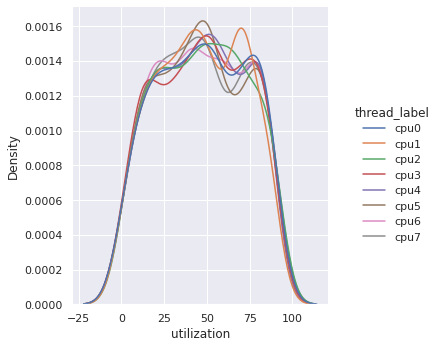

In [239]:
sns.displot(cpu_df, x="utilization", kind='kde', hue='thread_label')

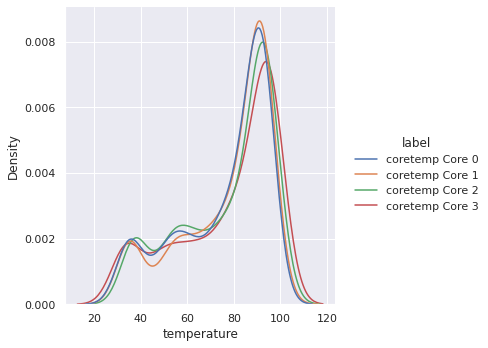

In [241]:
sns.displot(temp_df, x='temperature', kind='kde', hue='label')

**Observation** The temperature jumps to higher end from it's normal range of 40. We don't see temperature staying more in range of 50 to 70 degree celsius

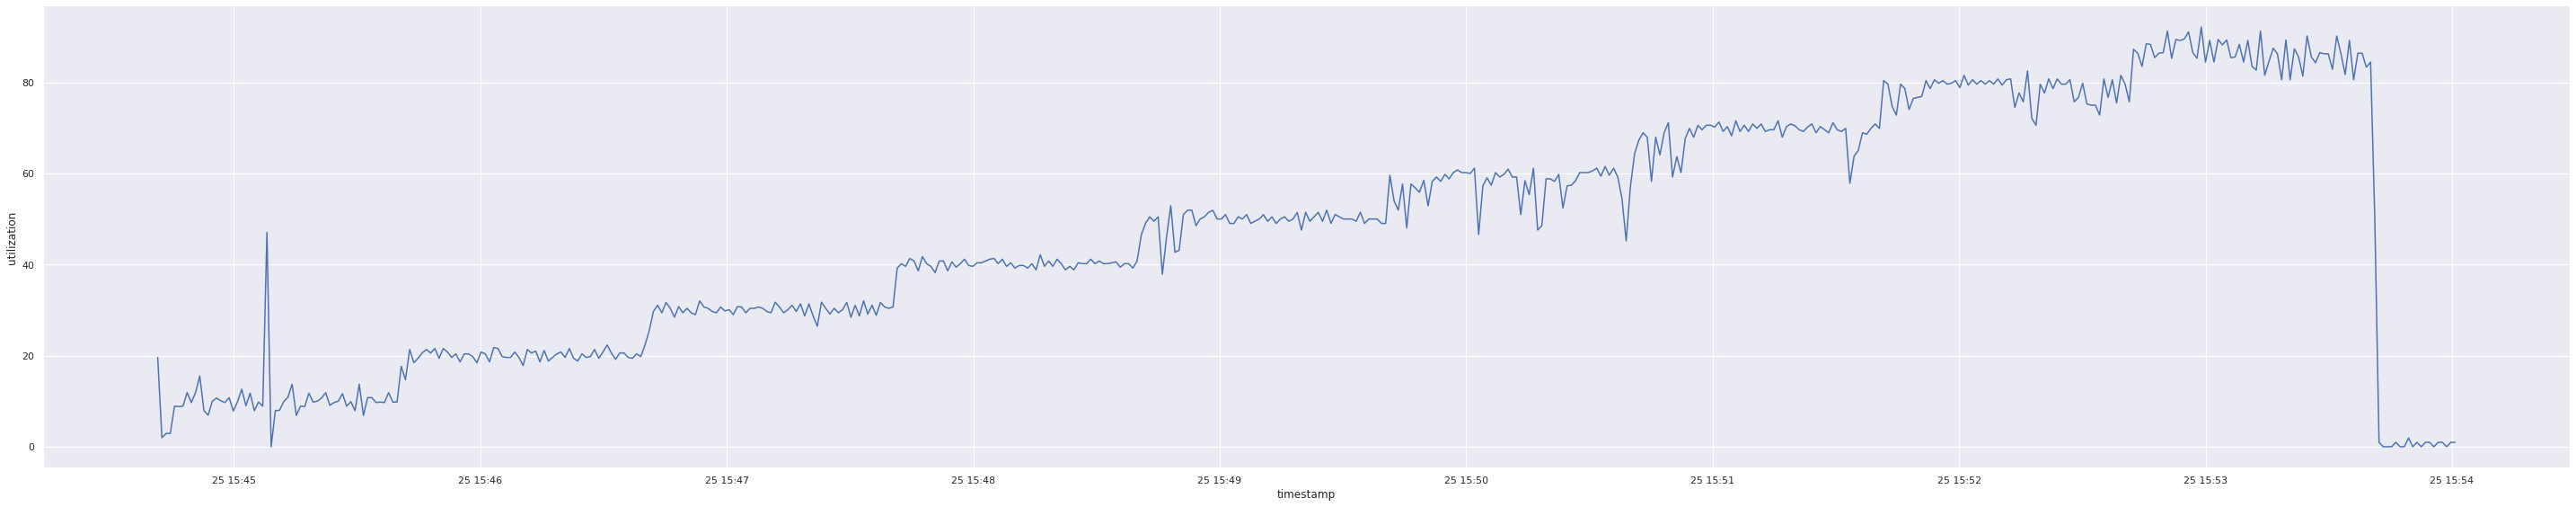

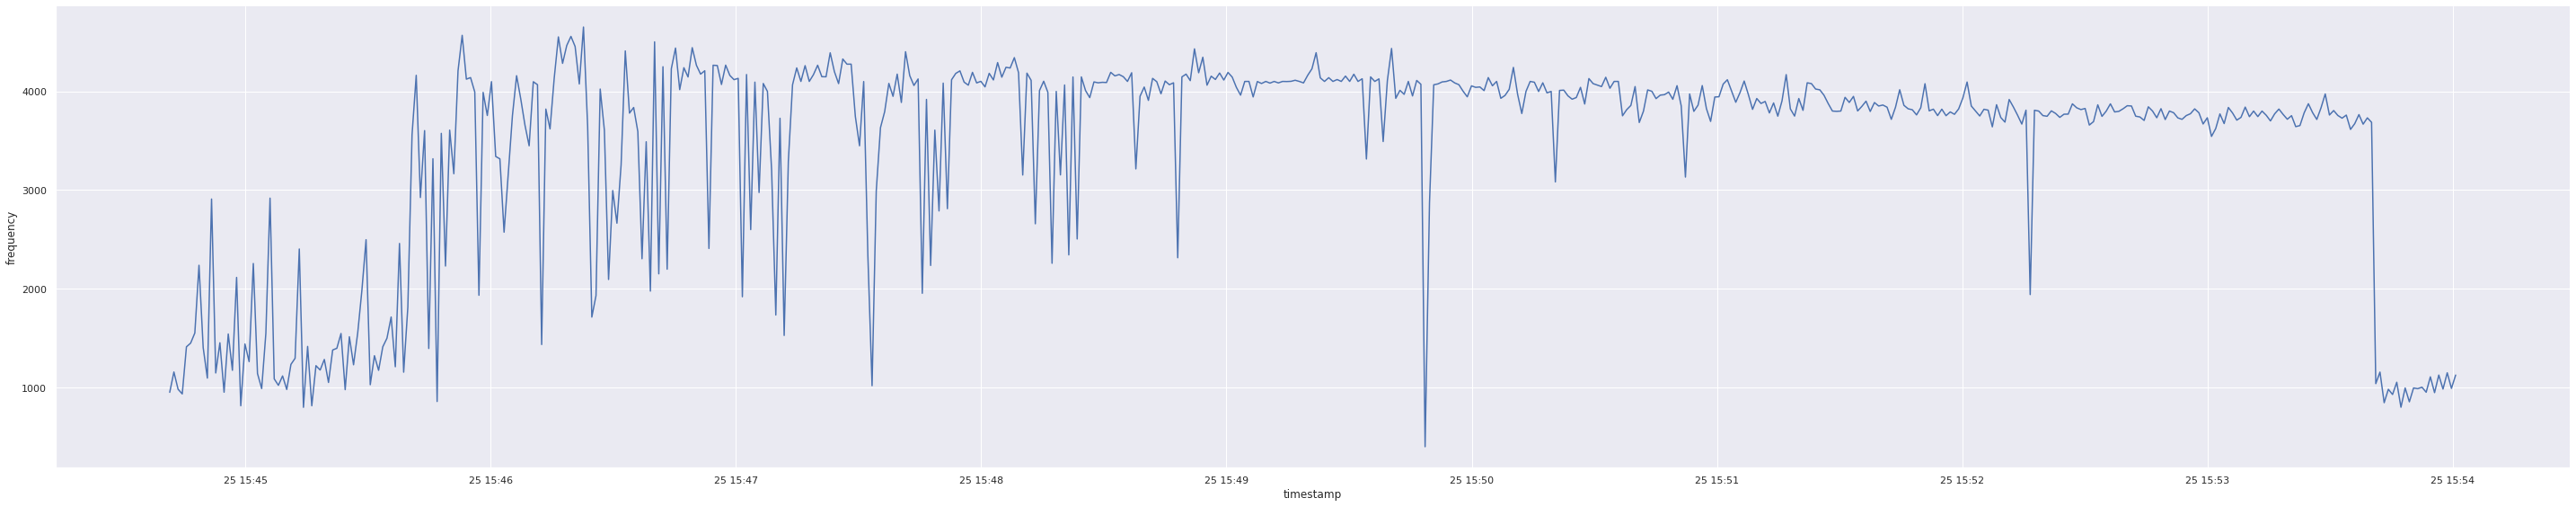

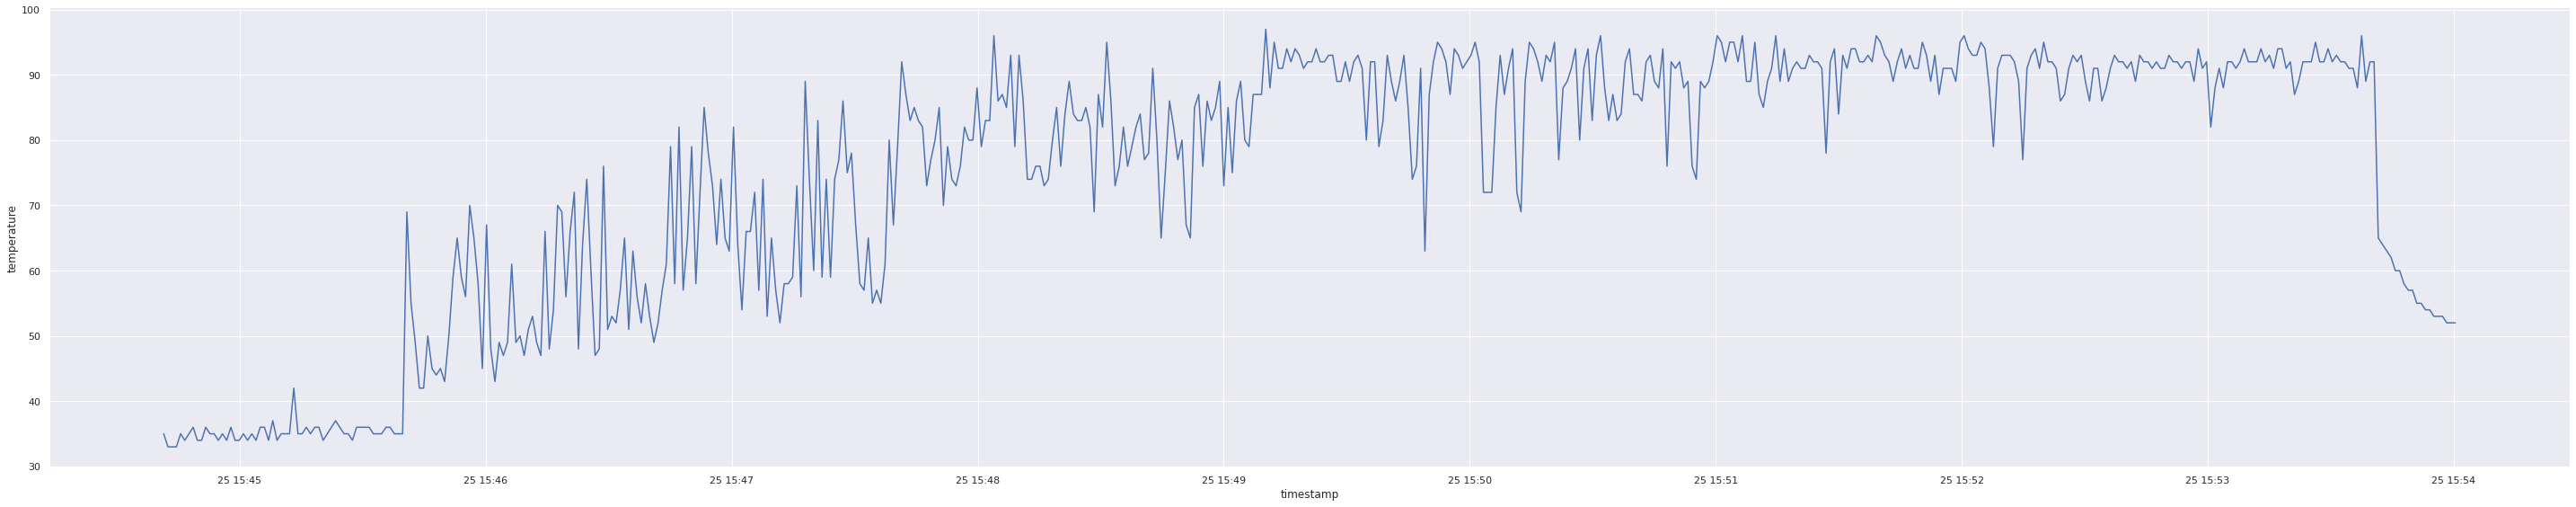

In [193]:
sns.relplot(cpu0, x="timestamp", y="utilization", kind="line", height=8, aspect=5)
sns.relplot(cpu0, x="timestamp", y="frequency", kind="line", height=8, aspect=5)
sns.relplot(cpu0_temp, x="timestamp", y="temperature", kind="line", height=8, aspect=5)
plt.show()

**Observation** There appears to be a correlation between CPU clock frequency and CPU temperature, where an increase in clock frequency tends to result in an increase in CPU temperature and vice versa. This suggests that there may be a causal relationship between these two variables. However, it is important to note that other factors, such as workload and cooling, can also affect CPU temperature and should be considered when interpreting the results.

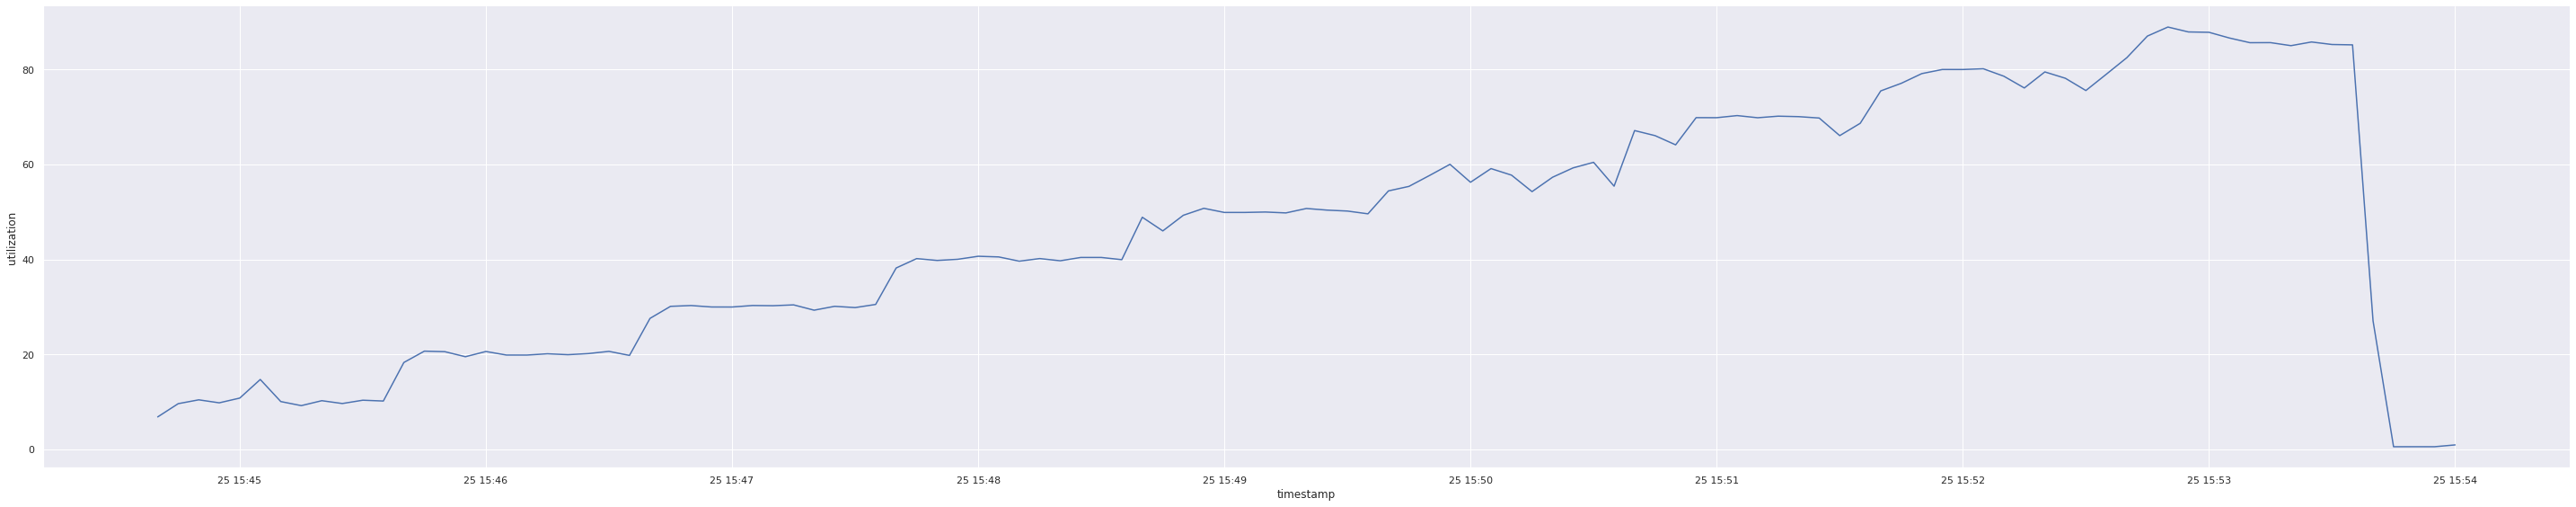

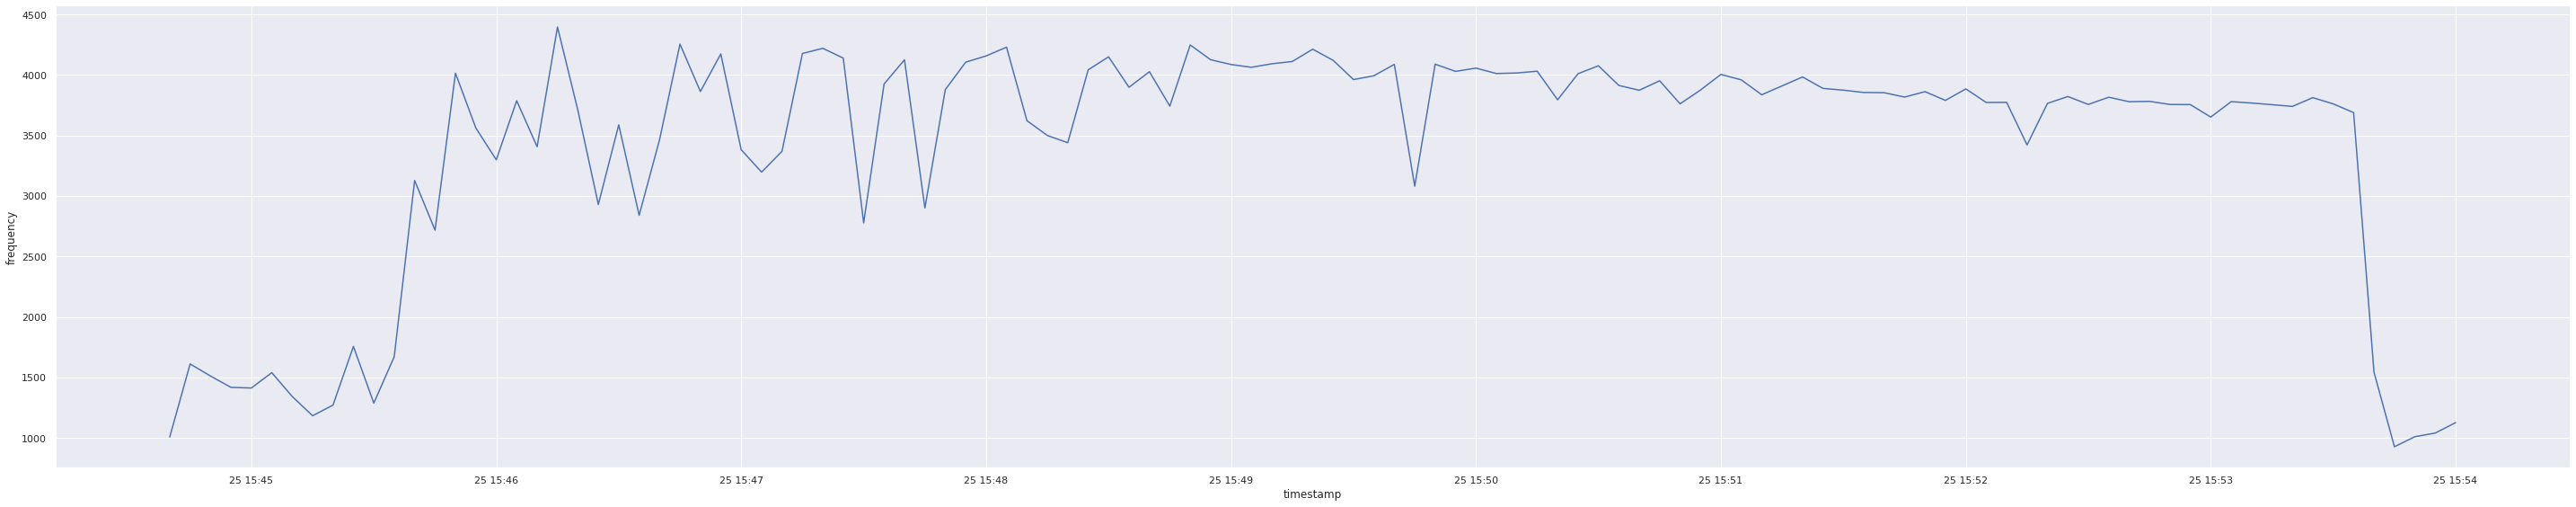

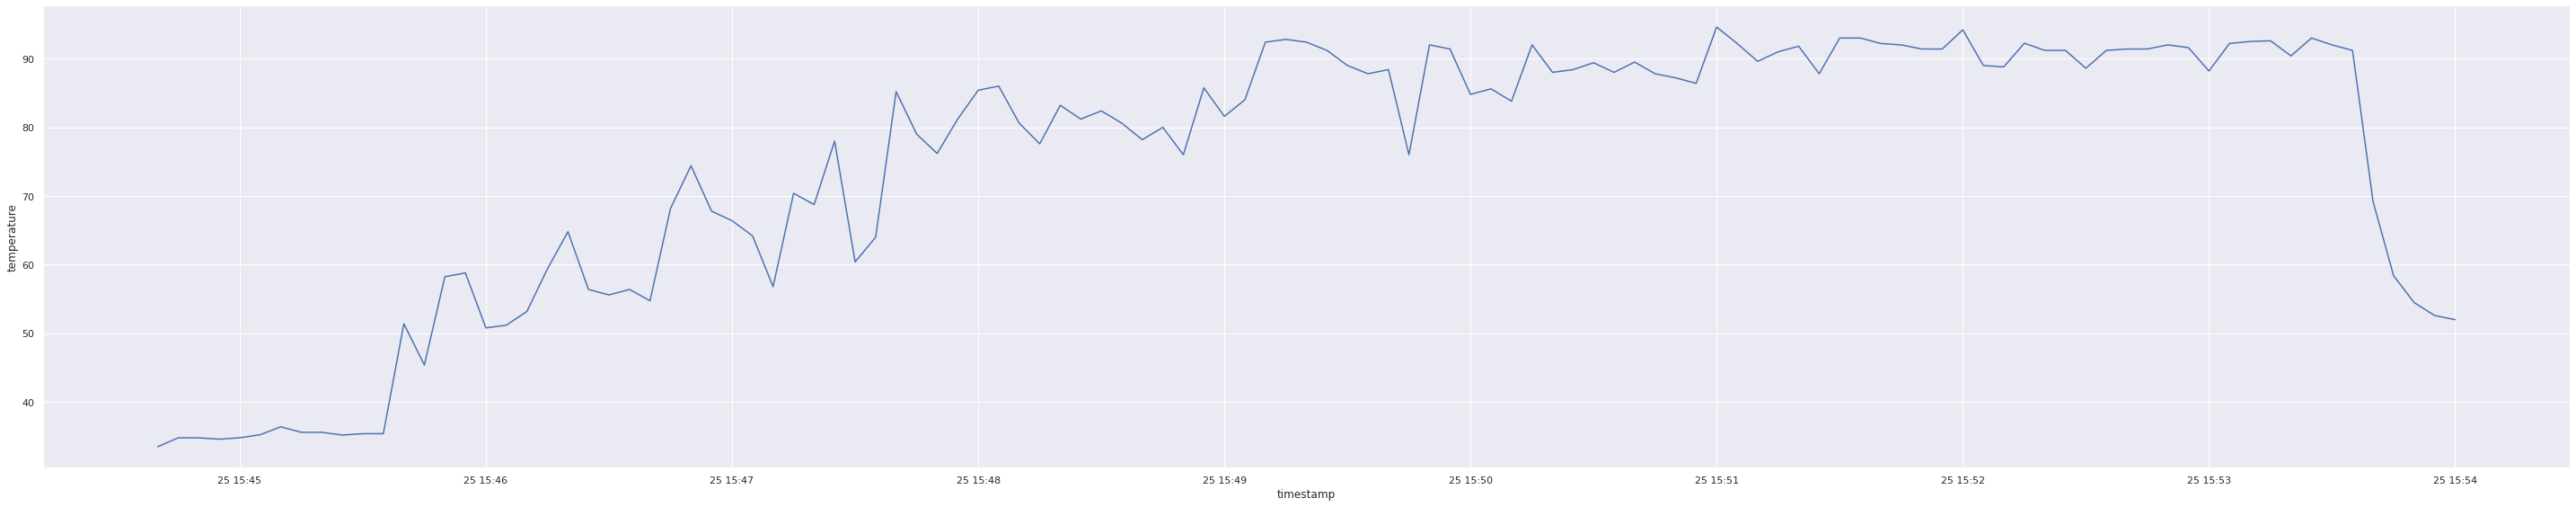

In [140]:
sns.relplot(
    cpu0_resampled, x="timestamp", y="utilization", kind="line", height=8, aspect=5
)
sns.relplot(
    cpu0_resampled, x="timestamp", y="frequency", kind="line", height=8, aspect=5
)
sns.relplot(
    cpu0_temp_resampled, x="timestamp", y="temperature", kind="line", height=8, aspect=5
)
plt.show()

**Observation** A sharp decline on CPU frequency does not result in sudden drop of temperature to it's original state which makes sense (Newton's law of cooling).

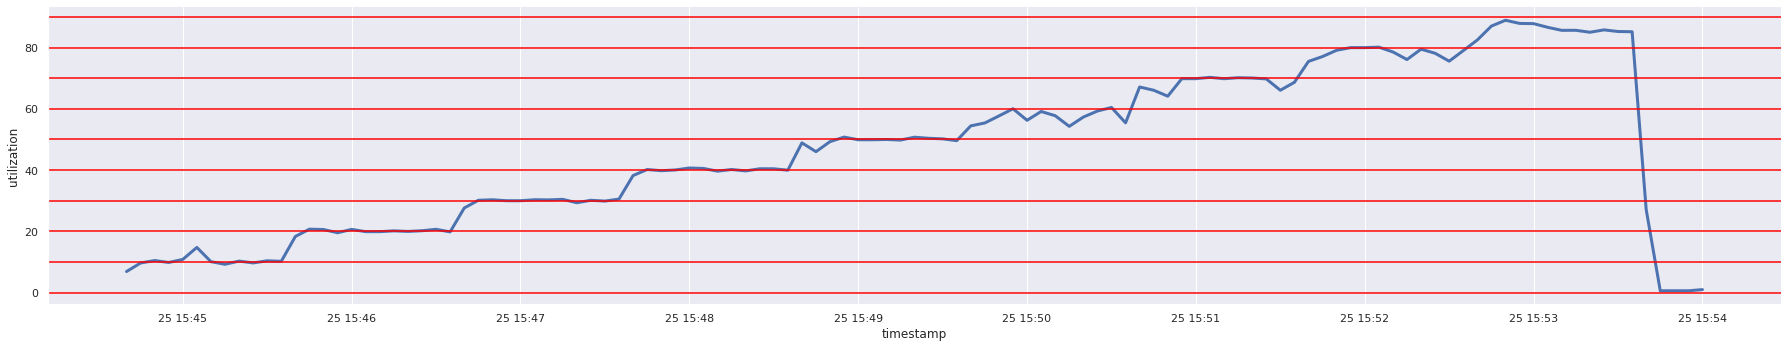

In [168]:
g = sns.relplot(
    cpu0_resampled,
    x="timestamp",
    y="utilization",
    height=5,
    aspect=5,
    kind="line",
    linewidth=3,
)
for y in range(0, 100, 10):
    g.ax.axhline(y=y, color="red", linestyle="solid")
plt.show()


**Observation** From utilization range of 10 to 50x the load seems to say constant for duration of 60 seconds (not considering the transition). Beyond this there is difficulty in maintaining the load constantly.

There is a possibility that there may be other processes or applications running on the system that are competing for CPU resources, causing the load generator to struggle to maintain high utilization levels.

To determine the root cause of the issue, we need to perform further analysis and testing of the system and the load generator software. This could involve monitoring CPU performance metrics, analyzing system logs, and profiling the load generator software to identify any performance bottlenecks or inefficiencies.

In [204]:
import scipy.signal as signal

b, a = signal.butter(2, 0.1, "low")

# Butterworth low pass filter with a cutoff frequency of 0.1, which means that frequencies above 0.1 will be attenuated
cpu0_resampled["cpu_filtered"] = signal.filtfilt(b, a, cpu0_resampled["utilization"])

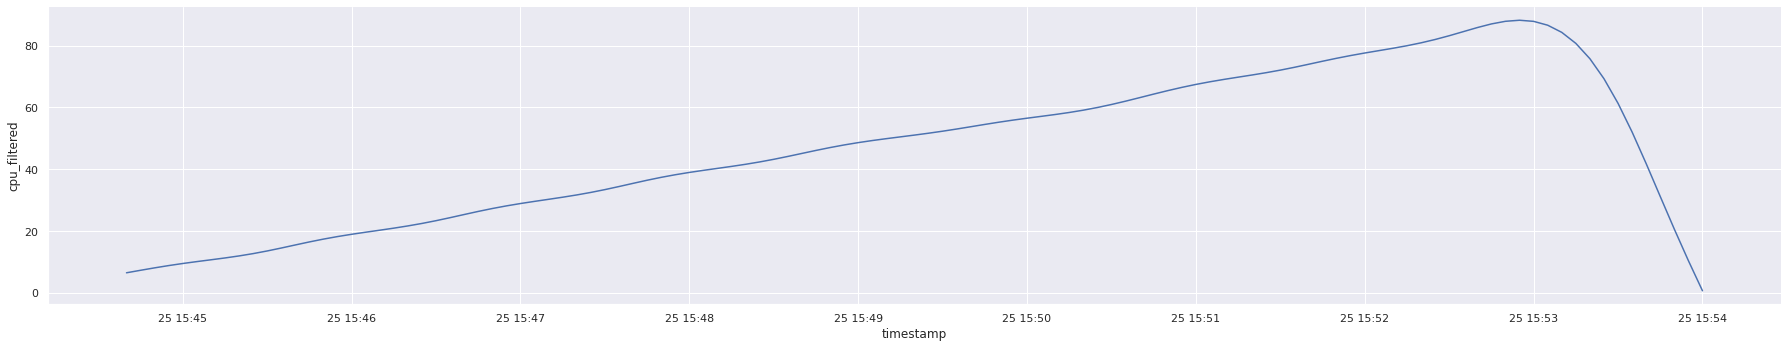

In [206]:
g = sns.relplot(
    cpu0_resampled,
    x="timestamp",
    y="cpu_filtered",
    height=5,
    aspect=5,
    kind="line",
)


In [194]:
cpu_df_pivot = cpu_df.pivot(
    index="timestamp", columns="thread_label", values="utilization"
)

In [195]:
cpu_df_pivot.describe()


thread_label,cpu0,cpu1,cpu2,cpu3,cpu4,cpu5,cpu6,cpu7
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,47.228077,46.227966,47.117520,46.769447,46.802101,46.649362,46.676977,46.810520
std,25.952885,25.039631,25.773340,25.862449,25.565078,25.756835,25.776539,25.970208
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.960785,28.294722,24.019608,23.663848,25.303398,28.224347,22.384828,26.522940
50%,49.038460,48.039215,49.262279,49.514560,49.019608,48.543690,48.039215,47.524754
75%,69.902916,69.607840,68.627460,69.829147,68.549802,69.156091,68.932040,69.902916
max,92.156860,91.176470,90.291260,91.262140,90.384610,91.346150,90.291260,91.176470


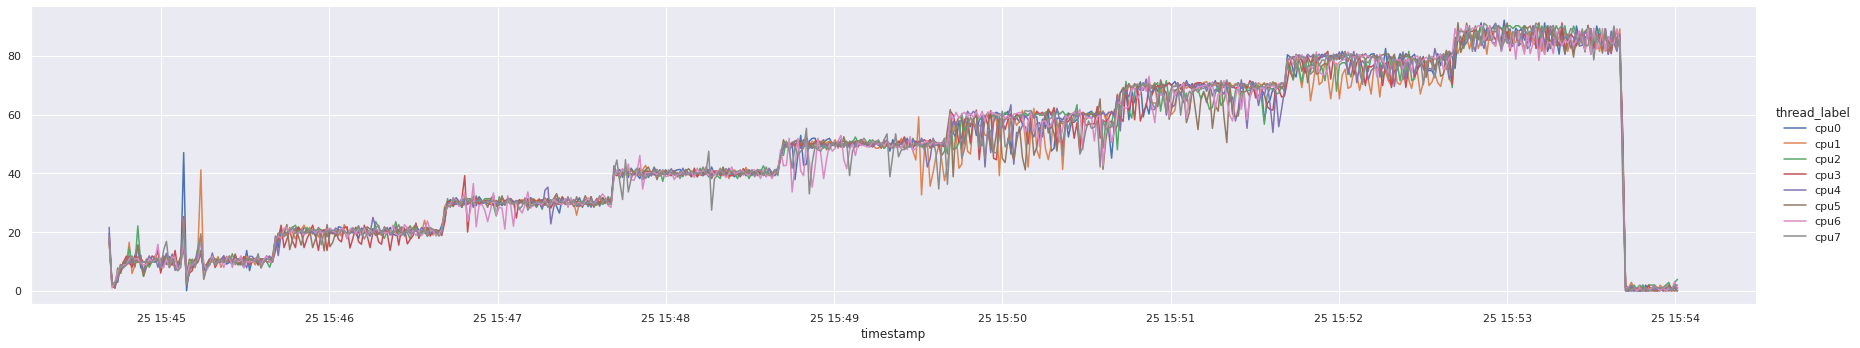

In [199]:
sns.relplot(data=cpu_df_pivot, height=5, aspect=5, kind="line", dashes=False)


**Observation** The profile sets the CPU utilization to be at 90% for all the cores at the last. Unlike other utilization levels, this load level is not reached. At last the CPU utilization seems to be fluctuating between 80% and 90%.

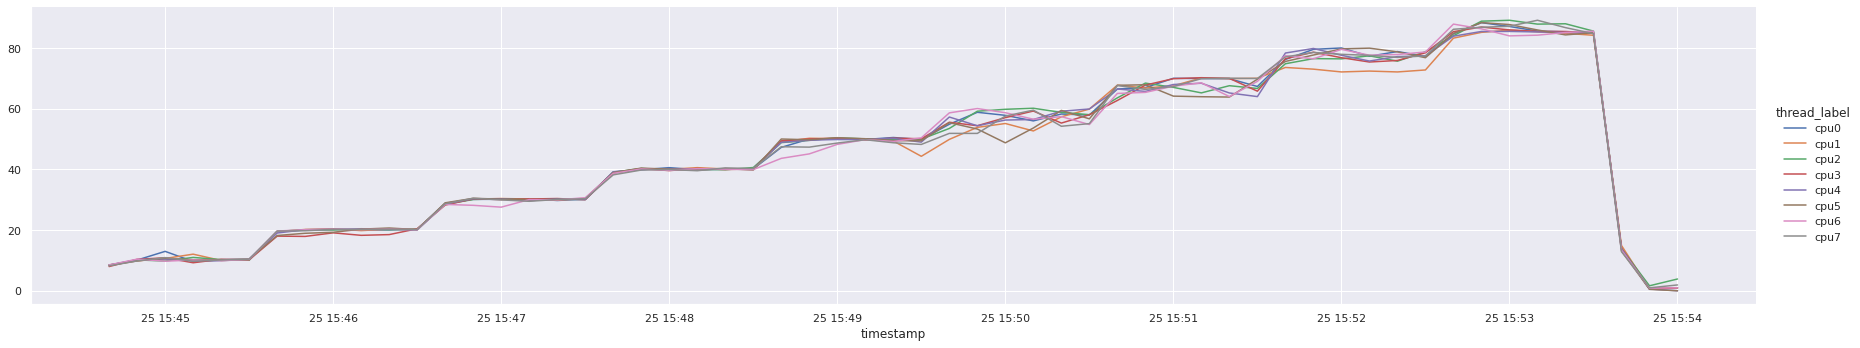

In [200]:
cpu_pivot_resampled = cpu_df_pivot.resample("10S").mean()
sns.relplot(data=cpu_pivot_resampled, height=5, aspect=5, kind="line", dashes=False)


In [196]:
temp_df_pivot = temp_df.pivot(index="timestamp", columns="label", values="temperature")

In [197]:
temp_df_pivot.describe()


label,coretemp Core 0,coretemp Core 1,coretemp Core 2,coretemp Core 3
count,548.000000,548.000000,548.000000,548.000000
mean,75.470803,76.647810,76.689781,76.958029
std,19.712677,19.488947,19.981127,21.559324
min,33.000000,33.000000,34.000000,31.000000
25%,60.000000,65.000000,61.750000,62.000000
50%,85.000000,86.000000,85.500000,85.000000
75%,92.000000,92.000000,93.000000,95.000000
max,97.000000,100.000000,100.000000,100.000000


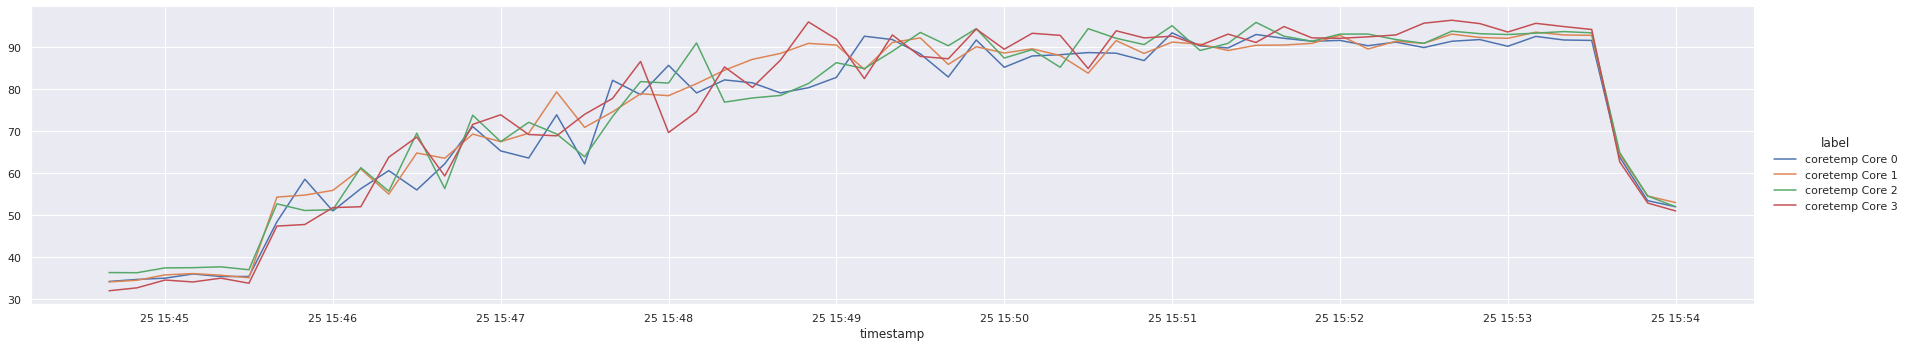

In [201]:
temp_pivot_resampled = temp_df_pivot.resample("10S").mean()
sns.relplot(data=temp_pivot_resampled, height=5, aspect=5, kind="line", dashes=False)


In [207]:
temp_pivot_resampled["mean_temp"] = temp_pivot_resampled[
    ["coretemp Core 0", "coretemp Core 1", "coretemp Core 2", "coretemp Core 3"]
].mean(axis="columns")

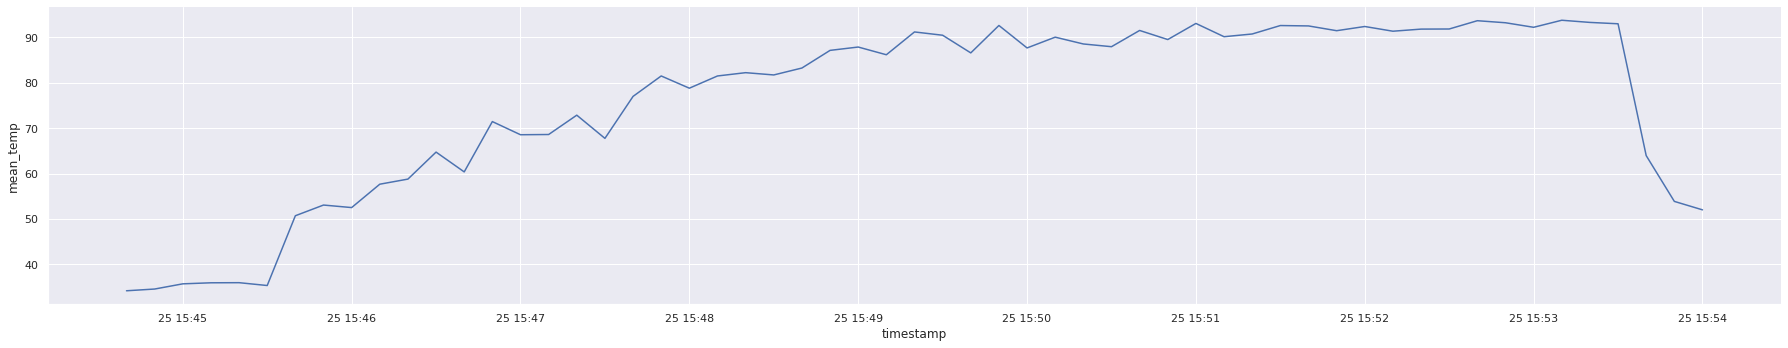

In [209]:
sns.relplot(
    data=temp_pivot_resampled,
    y="mean_temp",
    x="timestamp",
    height=5,
    aspect=5,
    kind="line",
)

**Observation** The CPU temperature has reached  80 to 90 Degree celsius in a shorter time and any further load does not seem to have any impact on the temperature changes.

In [145]:
merged_df = pd.merge(cpu0_resampled, cpu0_temp_resampled, on="timestamp")


In [146]:
merged_df.describe()

,utilization,frequency,temperature
count,113.000000,113.000000,113.000000
mean,46.977097,3435.458850,75.196460
std,25.925303,948.301428,19.163207
min,0.578790,926.400000,33.500000
25%,27.087379,3407.600000,59.400000
50%,49.615384,3795.400000,84.000000
75%,69.855295,4015.500000,91.200000
max,88.943764,4397.200000,94.600000


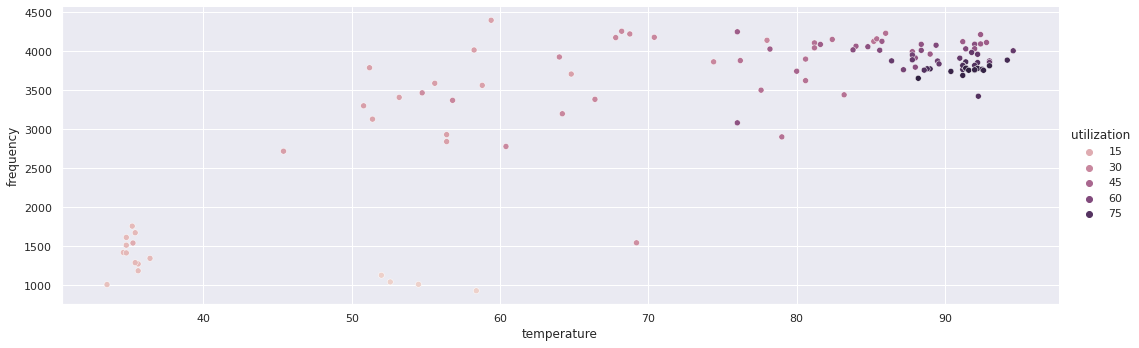

In [178]:
sns.relplot(
    data=merged_df,
    x="temperature",
    y="frequency",
    hue="utilization",
    height=5,
    aspect=3,
)


**Observation** The clock frequency ranges from 1 GHz to about 4 GHz. At higher loads it can be clearly observed that clock frequency is closer to 4 GHz. For this configuration the Max Turbo Frequency is 4.70 GHz.

In the utilization range of 30-50 one can notice the clock frequency going beyond 4 Ghz and temperature is between 60 to 80 degree celsius. Modern processors have sophisticated power management systems that can regulate the amount of power delivered to the CPU based on workload and thermal conditions. If the CPU is operating at a higher clock frequency, but is not experiencing a heavy workload, the power management system may be able to reduce power consumption and keep temperatures low. 

Intel® Turbo Boost Technology enhances clock speed dynamically to deal with heavy workloads. The technology judges the amount of heat the system can tolerate, as well as the number of cores in use, and then boosts clock speed to the maximum safe level. 

https://ark.intel.com/content/www/us/en/ark/products/208921/intel-core-i71165g7-processor-12m-cache-up-to-4-70-ghz-with-ipu.html

In [148]:
cpu_df["bin"] = pd.cut(
    cpu_df["utilization"], bins=list(range(0, 100, 5)), labels=list(range(5, 100, 5))
)

In [149]:
data = []

for _, gdf in cpu_df.groupby("bin"):
    data.append(
        {"utilization": gdf["utilization"].mean(), "frequency": gdf["frequency"].mean()}
    )

util_freq = pd.DataFrame(data)

In [150]:
util_freq


,utilization,frequency
0,1.701805,915.208696
1,8.881816,1276.182186
2,11.646520,1584.147727
3,18.926192,3215.667984
4,21.168569,3139.506329
5,29.018605,3702.387755
6,30.938553,3549.102941
7,39.184754,3789.563063
8,41.078868,3607.397213
9,48.914852,3786.300000


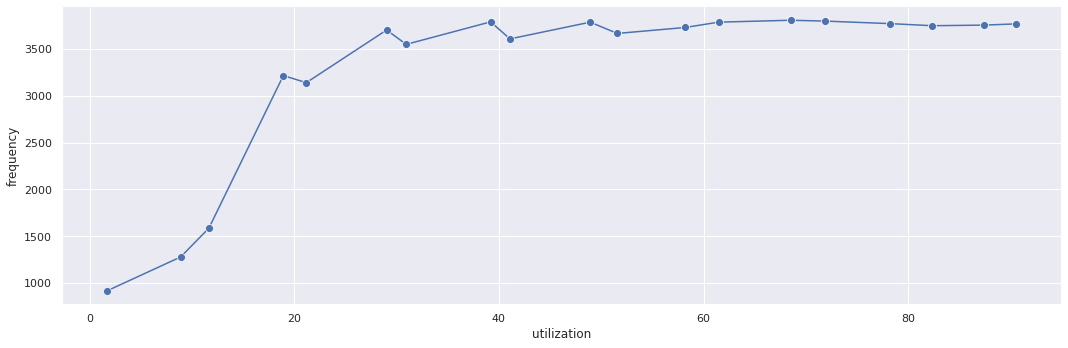

In [172]:
sns.relplot(
    data=util_freq,
    kind="line",
    x="utilization",
    y="frequency",
    markers=True,
    markersize=8,
    marker="o",
    height=5,
    aspect=3,
)


**Observation** Clock frequency stays almost constant beyond 50% utilization

In [254]:
merged_df["bin"] = pd.cut(
    merged_df["utilization"], bins=list(range(0, 100, 2)), labels=list(range(2, 100, 2))
)

data = []

for _, gdf in merged_df.groupby("bin"):
    data.append(
        {
            "utilization": gdf["utilization"].mean(),
            "frequency": gdf["frequency"].mean(),
            "temperature": gdf["temperature"].mean(),
        }
    )

util_freq_temp = pd.DataFrame(data)

In [255]:
len(util_freq_temp)

49

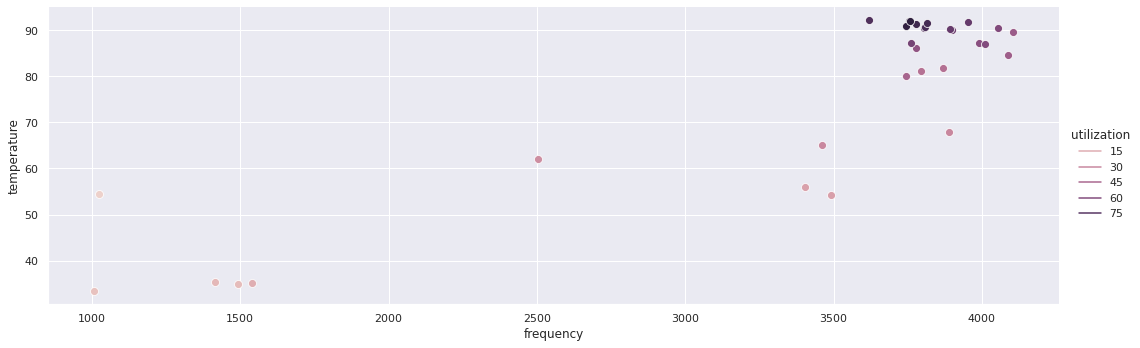

In [262]:
sns.relplot(
    data=util_freq_temp,
    x="frequency",
    y="temperature",
	hue='utilization',
	kind='line',
    height=5,
    aspect=3,
	markers=True,
    markersize=8,
    marker="o",
	# palette='colorblind'
)